In [42]:
import numpy as np
import pandas as pd

In [2]:
!pip install torchinfo

In [43]:
import PIL
import os 
import glob
import cv2

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
import torch.optim as optim
from IPython.display import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

# EDA

In [5]:
path = '/kaggle/input/covidct/'

pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

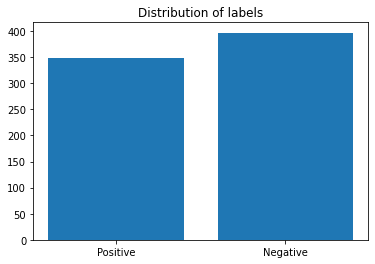

In [6]:
num_pos, num_neg = len(pos_files), len(neg_files)

plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg])
plt.show()

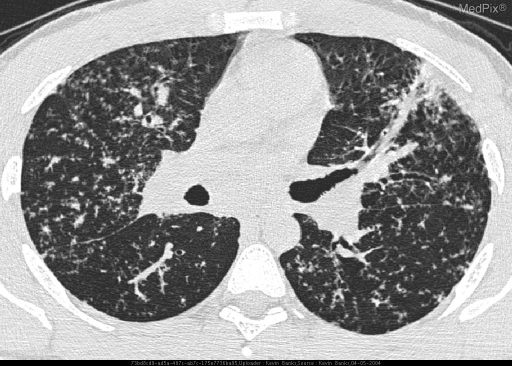

In [7]:
Image(images_train[1])
Image(images_train[15])
Image(images_train[66])

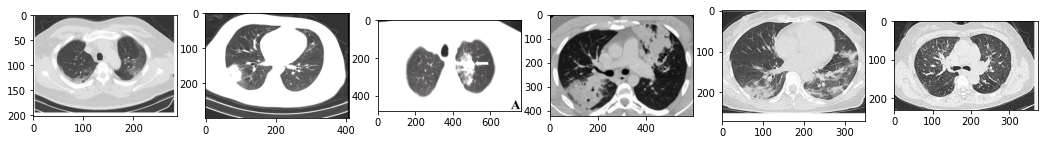

In [8]:
im = [cv2.imread(images_train[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

# Reading data

In [9]:
transform = transforms.Compose([transforms.Resize((250,250)),
                                 transforms.Grayscale(),
                                 transforms.ToTensor()])

In [10]:
dataset = datasets.ImageFolder('/kaggle/input/covidct', transform=transform)

In [11]:
dataset

Dataset ImageFolder
    Number of datapoints: 746
    Root location: /kaggle/input/covidct
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [12]:
len(dataset)

746

In [13]:
images_train, images_test = random_split(dataset, [600, 146], generator=torch.Generator().manual_seed(42))

# Data Augmentation

In [14]:
img_trans = transforms.Compose([transforms.Grayscale(),
                                transforms.RandomRotation(11),
                                transforms.Resize((250, 250)),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(degrees=0, scale=(1.1, 1.1), shear=0.9),
                                transforms.ToTensor()
                                ])

train_dataset_og = images_train
train_dataset_aug = images_train
train_dataset_aug.dataset.transform = img_trans
train_dataset_fin = torch.utils.data.ConcatDataset([train_dataset_og,train_dataset_aug])

# Training Models Functions

In [15]:
def getMetrics(conf_matrix):
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    f1 = 2*precision*recall/(precision + recall)
    return (precision, recall, f1, accuracy)

In [20]:
def train_model(
    model,
    images_train,
    images_test,
    device, 
    lr=0.0001,
    epochs=30,
    batch_size=32,
    l2=0.00001,
    gamma=0.5,
    patience=7,
    folds=5):
    
    splits=KFold(
        n_splits=folds,
        shuffle=True,
        random_state=42
    )
    
    foldperf={}
    
    model= nn.DataParallel(model)
    model = model.to(device)
    
    test_dataset = DataLoader(images_test, batch_size=32, shuffle=False, num_workers=2)
    
    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(images_train)))):
        print('Fold {}'.format(fold + 1))
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_dataset = DataLoader(images_train, batch_size=batch_size, sampler=train_sampler)
        val_dataset = DataLoader(images_train, batch_size=batch_size, sampler=val_sampler)
        
        # construct dataloader
        train_loader = train_dataset
        val_loader = val_dataset
        test_loader = test_dataset

        nb_classes = 2

        # history
        history = {'train_loss': [],
                   'train_acc': [],
                   'train_precision': [],
                   'train_recall': [],
                   'train_f1': [],
                   'val_loss': [], 
                   'val_acc': [], 
                   'val_precision': [],
                   'val_recall': [], 
                   'val_f1': []
                  }

        # set up loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

        # Training Loop
        print("Training Start:")
        for epoch in range(epochs):
            model.train()  # start to train the model, activate training behavior

            train_loss = 0
            train_acc = 0
            val_loss = 0
            val_acc = 0

            confusion_matrix_train = torch.zeros(nb_classes, nb_classes)

            for i, (images, labels) in enumerate(train_loader):
                # reshape images
                labels = labels.float()
                images = images.to(device)
                labels = labels.to(device)  # move to device
                # forward
                outputs = model(images).view(-1)  # forward
                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)

                cur_train_loss = criterion(outputs, labels)  # loss
                cur_train_acc = (pred == labels).sum().item() / batch_size

                for t, p in zip(labels.view(-1), pred.view(-1)):
                    confusion_matrix_train[t.long(), p.long()] += 1

                # backward
                cur_train_loss.backward()   # run back propagation
                optimizer.step()            # optimizer update all model parameters
                optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

                # loss
                train_loss += cur_train_loss 
    #             train_acc += cur_train_acc

            precision_train, recall_train, f1_train, accuracy_train = getMetrics(confusion_matrix_train)

            # valid
            model.eval()  # start to train the model, activate training behavior
            confusion_matrix_val = torch.zeros(nb_classes, nb_classes)
            
            with torch.no_grad():  # tell pytorch not to update parameters
                for images, labels in val_loader:
                    # calculate validation loss
                    labels = labels.float()
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images).view(-1)

                    # loss
                    cur_valid_loss = criterion(outputs, labels)
                    val_loss += cur_valid_loss
                    
                    pred = torch.sigmoid(outputs)
                    pred = torch.round(pred)

                    for t, p in zip(labels.view(-1), pred.view(-1)):
                        confusion_matrix_val[t.long(), p.long()] += 1

            precision_val, recall_val, f1_val, accuracy_val = getMetrics(confusion_matrix_val)

            # learning schedule step
            scheduler.step()

            # print training feedback
            train_loss = train_loss / len(train_loader)
            train_acc = accuracy_train
            val_loss = val_loss / len(val_loader)
            val_acc = accuracy_val

            print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

            # update history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['train_precision'].append(precision_train)
            history['train_recall'].append(recall_train)
            history['train_f1'].append(f1_train)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_precision'].append(precision_val)
            history['val_recall'].append(recall_val)
            history['val_f1'].append(f1_val)
            
        foldperf['fold{}'.format(fold+1)] = history
    
    trainLoss=[]
    trainAcc=[]
    trainPrec=[]
    trainRec=[]
    trainF1=[]
    valLoss=[]
    valAcc=[]
    valPrec=[]
    valRec=[]
    valF1=[]
    
    for f in range(1,folds+1):
        trainLoss.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_loss']).numpy()))
        trainAcc.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_acc']).numpy()))
        trainPrec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_precision']).numpy()))
        trainRec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_recall']).numpy()))
        trainF1.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_f1']).numpy()))

        valLoss.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_loss']).numpy()))
        valAcc.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_acc']).numpy()))
        valPrec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_precision']).numpy()))
        valRec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_recall']).numpy()))
        valF1.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_f1']).numpy()))

    print('\n\nPerformance of {} fold cross validation'.format(folds))
    print(
        "Average Training Loss     : {:.3f}\
        \n Average Training Accuracy : {:.3f}\
        \n Average Training Precision: {:.2f}\
        \n Average Training Recall   : {:.2f}\
        \n Average Training F1       : {:.2f}\n\n"
        .format(np.mean(trainLoss),np.mean(trainAcc),np.mean(trainPrec),np.mean(trainRec),np.mean(trainF1)))
    print(
        "Average Validation Loss     : {:.3f}\
        \n Average Validation Accuracy : {:.3f}\
        \n Average Validation Precision: {:.2f}\
        \n Average Validation Recall   : {:.2f}\
        \n Average Validation F1       : {:.2f}\n\n"
        .format(np.mean(valLoss),np.mean(valAcc),np.mean(valPrec),np.mean(valRec),np.mean(valF1)))


    test_acc = 0
    confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
    
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            
            # calculate outputs by running images through the network
            outputs = model(images)
            
            # the class with the highest energy is what we choose as prediction
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)

            test_acc += (pred == labels).sum().item()
            for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

    precision_test, recall_test, f1_test, accuracy_test = getMetrics(confusion_matrix_test)

    print(f'\n\nTest Accuracy:', accuracy_test, '\nTest Precision:', precision_test, '\nTest Recall:', recall_test, '\nTest F1:', f1_test)
    print('Train\n', confusion_matrix_train)
    print('Val\n', confusion_matrix_val)
    print('Test\n', confusion_matrix_test)

    return foldperf

In [16]:
def train_modell(model, images_train, images_test, device, lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5, patience=7, folds=5):
    
    splits=KFold(
        n_splits=folds,
        shuffle=True,
        random_state=42
    )
    
    foldperf={}
    
    model= nn.DataParallel(model)
    model = model.to(device)
    
    test_dataset = DataLoader(images_test, batch_size=32, shuffle=False, num_workers=2)
    
    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(images_train)))):
        print('Fold {}'.format(fold + 1))
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_dataset = DataLoader(images_train, batch_size=batch_size, sampler=train_sampler)
        val_dataset = DataLoader(images_train, batch_size=batch_size, sampler=val_sampler)
        
        # construct dataloader
        train_loader = train_dataset
        val_loader = val_dataset
        test_loader = test_dataset

        nb_classes = 2

        # history
        history = {'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

        # set up loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

        # Training Loop
        print("Training Start:")
        for epoch in range(epochs):
            model.train()  # start to train the model, activate training behavior

            train_loss = 0
            train_acc = 0
            val_loss = 0
            val_acc = 0

            confusion_matrix_train = torch.zeros(nb_classes, nb_classes)

            for i, (images, labels) in enumerate(train_loader):
                # reshape images
                labels = labels.float()
                images = images.to(device)
                labels = labels.to(device)  # move to device
                # forward
                outputs = model(images).view(-1)  # forward
                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)

                cur_train_loss = criterion(outputs, labels)  # loss
                cur_train_acc = (pred == labels).sum().item() / batch_size

                for t, p in zip(labels.view(-1), pred.view(-1)):
                    confusion_matrix_train[t.long(), p.long()] += 1

                # backward
                cur_train_loss.backward()   # run back propagation
                optimizer.step()            # optimizer update all model parameters
                optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

                # loss
                train_loss += cur_train_loss 
    #             train_acc += cur_train_acc

            precision_train, recall_train, f1_train, accuracy_train = getMetrics(confusion_matrix_train)

            # valid
            model.eval()  # start to train the model, activate training behavior
            confusion_matrix_val = torch.zeros(nb_classes, nb_classes)
            with torch.no_grad():  # tell pytorch not to update parameters
                for images, labels in val_loader:
                    # calculate validation loss
                    labels = labels.float()
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images).view(-1)

                    # loss
                    cur_valid_loss = criterion(outputs, labels)
                    val_loss += cur_valid_loss
                    
                    pred = torch.sigmoid(outputs)
                    pred = torch.round(pred)

                    for t, p in zip(labels.view(-1), pred.view(-1)):
                        confusion_matrix_val[t.long(), p.long()] += 1

            precision_val, recall_val, f1_val, accuracy_val = getMetrics(confusion_matrix_val)

            # learning schedule step
            scheduler.step()

            # print training feedback
            train_loss = train_loss / len(train_loader)
            train_acc = accuracy_train
            val_loss = val_loss / len(val_loader)
            val_acc = accuracy_val

            print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

            # update history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['train_precision'].append(precision_train)
            history['train_recall'].append(recall_train)
            history['train_f1'].append(f1_train)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_precision'].append(precision_val)
            history['val_recall'].append(recall_val)
            history['val_f1'].append(f1_val)
            
        foldperf['fold{}'.format(fold+1)] = history
    
    trainLoss, trainAcc, trainPrec, trainRec, trainF1, valLoss, valAcc, valPrec,valRec,valF1=[],[],[],[],[],[],[],[],[],[]
    for f in range(1,folds+1):
        trainLoss.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_loss']).numpy()))
        trainAcc.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_acc']).numpy()))
        trainPrec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_precision']).numpy()))
        trainRec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_recall']).numpy()))
        trainF1.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['train_f1']).numpy()))

        valLoss.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_loss']).numpy()))
        valAcc.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_acc']).numpy()))
        valPrec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_precision']).numpy()))
        valRec.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_recall']).numpy()))
        valF1.append(np.mean(torch.tensor(foldperf['fold{}'.format(f)]['val_f1']).numpy()))

    print('\n\nPerformance of {} fold cross validation'.format(folds))
    print(
        "Average Training Loss     : {:.3f}\
        \n Average Training Accuracy : {:.3f}\
        \n Average Training Precision: {:.2f}\
        \n Average Training Recall   : {:.2f}\
        \n Average Training F1       : {:.2f}\n\n"
        .format(np.mean(trainLoss),np.mean(trainAcc),np.mean(trainPrec),np.mean(trainRec),np.mean(trainF1)))
    print(
        "Average Validation Loss     : {:.3f}\
        \n Average Validation Accuracy : {:.3f}\
        \n Average Validation Precision: {:.2f}\
        \n Average Validation Recall   : {:.2f}\
        \n Average Validation F1       : {:.2f}\n\n"
        .format(np.mean(valLoss),np.mean(valAcc),np.mean(valPrec),np.mean(valRec),np.mean(valF1)))


    test_acc = 0
    confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)

            test_acc += (pred == labels).sum().item()
            for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

    precision_test, recall_test, f1_test, accuracy_test = getMetrics(confusion_matrix_test)

    print(f'\n\nTest Accuracy:', accuracy_test, '\nTest Precision:', precision_test, '\nTest Recall:', recall_test, '\nTest F1:', f1_test)
    print('Train\n', confusion_matrix_train)
    print('Val\n', confusion_matrix_val)
    print('Test\n', confusion_matrix_test)

    return foldperf

# Models

## Model 1
* data aug
* batch norm
* dropout

64, 128, 256, 512, 512

In [17]:
class Convnet_1(nn.Module):

    def __init__(self):
        super(Convnet_1, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 12800, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(0.7),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [18]:
cnn_model_1 = Convnet_1()
summary(cnn_model_1, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_1                                [32, 1]                   --
├─Sequential: 1-1                        [32, 12800]               --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─ReLU: 2-2                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-3                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-4                       [32, 128, 122, 122]       73,856
│    └─ReLU: 2-5                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-6                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-7                       [32, 256, 59, 59]         295,168
│    └─ReLU: 2-8                         [32, 256, 59, 59]         --
│    └─MaxPool2d: 2-9                    [32, 256, 29, 29]         --
│    └─Conv2d: 2-10                      [32, 512, 27, 27]         1,180,160
│    └─ReLU: 2-11                        [32, 512, 27, 27]         -

In [19]:
# print(cnn_model_1)

### model_1_1

In [21]:
class Convnet_1_1(nn.Module):

    def __init__(self):
        super(Convnet_1_1, self).__init__()
        self.convnet = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=1), 
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(in_features= 25088, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(0.6),
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [22]:
cnn_model_1_1 = Convnet_1_1()
summary(cnn_model_1_1, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_1_1                              [32, 1]                   --
├─Sequential: 1-1                        [32, 25088]               --
│    └─Conv2d: 2-1                       [32, 64, 251, 251]        320
│    └─ReLU: 2-2                         [32, 64, 251, 251]        --
│    └─MaxPool2d: 2-3                    [32, 64, 125, 125]        --
│    └─Conv2d: 2-4                       [32, 128, 125, 125]       73,856
│    └─ReLU: 2-5                         [32, 128, 125, 125]       --
│    └─MaxPool2d: 2-6                    [32, 128, 62, 62]         --
│    └─Conv2d: 2-7                       [32, 256, 61, 61]         524,544
│    └─ReLU: 2-8                         [32, 256, 61, 61]         --
│    └─MaxPool2d: 2-9                    [32, 256, 30, 30]         --
│    └─Conv2d: 2-10                      [32, 512, 29, 29]         2,097,664
│    └─ReLU: 2-11                        [32, 512, 29, 29]         -

In [23]:
print(cnn_model_1_1)

Convnet_1_1(
  (convnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
 

### model_1_2

In [24]:
class Convnet_1_2(nn.Module):

    def __init__(self):
        super(Convnet_1_2, self).__init__()
        self.convnet = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=1),  
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2), 
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),  

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
            
          nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features= 32768, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [25]:
cnn_model_1_2 = Convnet_1_2()
summary(cnn_model_1_2, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_1_2                              [32, 1]                   --
├─Sequential: 1-1                        [32, 32768]               --
│    └─Conv2d: 2-1                       [32, 64, 251, 251]        320
│    └─ReLU: 2-2                         [32, 64, 251, 251]        --
│    └─MaxPool2d: 2-3                    [32, 64, 125, 125]        --
│    └─Conv2d: 2-4                       [32, 128, 127, 127]       73,856
│    └─ReLU: 2-5                         [32, 128, 127, 127]       --
│    └─MaxPool2d: 2-6                    [32, 128, 63, 63]         --
│    └─Conv2d: 2-7                       [32, 256, 64, 64]         524,544
│    └─ReLU: 2-8                         [32, 256, 64, 64]         --
│    └─MaxPool2d: 2-9                    [32, 256, 32, 32]         --
│    └─Conv2d: 2-10                      [32, 512, 33, 33]         2,097,664
│    └─ReLU: 2-11                        [32, 512, 33, 33]         -

In [26]:
print(cnn_model_1_2)

Convnet_1_2(
  (convnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
 

## model_1_3

In [27]:
class Convnet_1_3(nn.Module):

    def __init__(self):
        super(Convnet_1_3, self).__init__()
        self.convnet = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),  
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1), 
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),  

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
            
          nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(in_features= 8192, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [28]:
cnn_model_1_3 = Convnet_1_3()
summary(cnn_model_1_3, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_1_3                              [32, 1]                   --
├─Sequential: 1-1                        [32, 8192]                --
│    └─Conv2d: 2-1                       [32, 64, 250, 250]        640
│    └─ReLU: 2-2                         [32, 64, 250, 250]        --
│    └─MaxPool2d: 2-3                    [32, 64, 125, 125]        --
│    └─Conv2d: 2-4                       [32, 128, 125, 125]       73,856
│    └─ReLU: 2-5                         [32, 128, 125, 125]       --
│    └─MaxPool2d: 2-6                    [32, 128, 62, 62]         --
│    └─Conv2d: 2-7                       [32, 256, 62, 62]         295,168
│    └─ReLU: 2-8                         [32, 256, 62, 62]         --
│    └─MaxPool2d: 2-9                    [32, 256, 31, 31]         --
│    └─Conv2d: 2-10                      [32, 512, 31, 31]         1,180,160
│    └─ReLU: 2-11                        [32, 512, 31, 31]         -

In [29]:
print(cnn_model_1_3)

Convnet_1_3(
  (convnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
 

## Model 2

128, 256, 512, 1024, 1024

In [30]:
class Convnet_2(nn.Module):
    
    def __init__(self):
        super(Convnet_2, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, padding=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten() 
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(in_features= 8192, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [31]:
cnn_model_2 = Convnet_2()
summary(cnn_model_2, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_2                                [32, 1]                   --
├─Sequential: 1-1                        [32, 8192]                --
│    └─Conv2d: 2-1                       [32, 128, 251, 251]       640
│    └─ReLU: 2-2                         [32, 128, 251, 251]       --
│    └─MaxPool2d: 2-3                    [32, 128, 125, 125]       --
│    └─Conv2d: 2-4                       [32, 128, 125, 125]       147,584
│    └─ReLU: 2-5                         [32, 128, 125, 125]       --
│    └─MaxPool2d: 2-6                    [32, 128, 62, 62]         --
│    └─Conv2d: 2-7                       [32, 256, 62, 62]         295,168
│    └─ReLU: 2-8                         [32, 256, 62, 62]         --
│    └─MaxPool2d: 2-9                    [32, 256, 31, 31]         --
│    └─Conv2d: 2-10                      [32, 256, 30, 30]         1,048,832
│    └─ReLU: 2-11                        [32, 256, 30, 30]         

## model_2_1

In [32]:
class Convnet_2_1(nn.Module):
    
    def __init__(self):
        super(Convnet_2_1, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, padding=2, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 18432, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [33]:
cnn_model_2_1 = Convnet_2_1()
summary(cnn_model_2_1, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_2_1                              [32, 1]                   --
├─Sequential: 1-1                        [32, 18432]               --
│    └─Conv2d: 2-1                       [32, 128, 253, 253]       640
│    └─ReLU: 2-2                         [32, 128, 253, 253]       --
│    └─MaxPool2d: 2-3                    [32, 128, 126, 126]       --
│    └─Conv2d: 2-4                       [32, 128, 128, 128]       147,584
│    └─ReLU: 2-5                         [32, 128, 128, 128]       --
│    └─MaxPool2d: 2-6                    [32, 128, 64, 64]         --
│    └─Conv2d: 2-7                       [32, 256, 66, 66]         295,168
│    └─ReLU: 2-8                         [32, 256, 66, 66]         --
│    └─MaxPool2d: 2-9                    [32, 256, 33, 33]         --
│    └─Conv2d: 2-10                      [32, 256, 34, 34]         1,048,832
│    └─ReLU: 2-11                        [32, 256, 34, 34]         

## model_2_2

In [34]:
class Convnet_2_2(nn.Module):
    
    def __init__(self):
        super(Convnet_2_2, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, padding=2, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 18432, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [35]:
cnn_model_2_2 = Convnet_2_2()
summary(cnn_model_2_2, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_2_2                              [32, 1]                   --
├─Sequential: 1-1                        [32, 18432]               --
│    └─Conv2d: 2-1                       [32, 128, 253, 253]       640
│    └─ReLU: 2-2                         [32, 128, 253, 253]       --
│    └─MaxPool2d: 2-3                    [32, 128, 126, 126]       --
│    └─Conv2d: 2-4                       [32, 128, 128, 128]       147,584
│    └─ReLU: 2-5                         [32, 128, 128, 128]       --
│    └─MaxPool2d: 2-6                    [32, 128, 64, 64]         --
│    └─Conv2d: 2-7                       [32, 256, 66, 66]         295,168
│    └─ReLU: 2-8                         [32, 256, 66, 66]         --
│    └─MaxPool2d: 2-9                    [32, 256, 33, 33]         --
│    └─Conv2d: 2-10                      [32, 256, 34, 34]         1,048,832
│    └─ReLU: 2-11                        [32, 256, 34, 34]         

## model_2_3

In [36]:
class Convnet_2_3(nn.Module):
    
    def __init__(self):
        super(Convnet_2_3, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, padding=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 4608, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [37]:
cnn_model_2_3 = Convnet_2_3()
summary(cnn_model_2_3, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_2_3                              [32, 1]                   --
├─Sequential: 1-1                        [32, 4608]                --
│    └─Conv2d: 2-1                       [32, 128, 251, 251]       640
│    └─ReLU: 2-2                         [32, 128, 251, 251]       --
│    └─MaxPool2d: 2-3                    [32, 128, 125, 125]       --
│    └─Conv2d: 2-4                       [32, 128, 124, 124]       262,272
│    └─ReLU: 2-5                         [32, 128, 124, 124]       --
│    └─MaxPool2d: 2-6                    [32, 128, 62, 62]         --
│    └─Conv2d: 2-7                       [32, 256, 57, 57]         2,097,408
│    └─ReLU: 2-8                         [32, 256, 57, 57]         --
│    └─MaxPool2d: 2-9                    [32, 256, 28, 28]         --
│    └─Conv2d: 2-10                      [32, 256, 27, 27]         1,048,832
│    └─ReLU: 2-11                        [32, 256, 27, 27]       

## Model 3

16, 32, 64, 128, 512

In [50]:
class Convnet_3(nn.Module):

    def __init__(self):
        super(Convnet_3, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, padding=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=16,padding=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32,padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64,padding=1, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=256, padding=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 16384, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [51]:
cnn_model_3 = Convnet_3()
summary(cnn_model_3, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet_3                                [32, 1]                   --
├─Sequential: 1-1                        [32, 16384]               --
│    └─Conv2d: 2-1                       [32, 16, 251, 251]        80
│    └─ReLU: 2-2                         [32, 16, 251, 251]        --
│    └─MaxPool2d: 2-3                    [32, 16, 125, 125]        --
│    └─Conv2d: 2-4                       [32, 16, 126, 126]        1,040
│    └─ReLU: 2-5                         [32, 16, 126, 126]        --
│    └─MaxPool2d: 2-6                    [32, 16, 63, 63]          --
│    └─Conv2d: 2-7                       [32, 32, 63, 63]          4,640
│    └─ReLU: 2-8                         [32, 32, 63, 63]          --
│    └─MaxPool2d: 2-9                    [32, 32, 31, 31]          --
│    └─Conv2d: 2-10                      [32, 64, 31, 31]          18,496
│    └─ReLU: 2-11                        [32, 64, 31, 31]          --
│    

## model_3_1

In [ ]:
class Convnet_3_1(nn.Module):

    def __init__(self):
        super(Convnet_3_1, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, padding=2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=16,padding=2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32,padding=2, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64,padding=2, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=256, padding=2, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(in_features= 25600, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [ ]:
cnn_model_3_1 = Convnet_3_1()
summary(cnn_model_3_1, (32, 1, 250, 250))

# Training models

## model 1
no data aug

In [39]:
# hist_1_no_aug = train_model(cnn_model_1, images_train, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

## model_1

In [32]:
hist_1 = train_model(cnn_model_1, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69412, train acc: 0.53333, valid loss:0.69219, valid acc:0.47083
Epoch:2 / 10, lr: 0.00020 train loss:0.68818, train acc: 0.54688, valid loss:0.67678, valid acc:0.54167
Epoch:3 / 10, lr: 0.00010 train loss:0.67681, train acc: 0.56771, valid loss:0.73030, valid acc:0.54167
Epoch:4 / 10, lr: 0.00010 train loss:0.66353, train acc: 0.60625, valid loss:0.68261, valid acc:0.56250
Epoch:5 / 10, lr: 0.00010 train loss:0.64694, train acc: 0.62187, valid loss:0.67007, valid acc:0.56250
Epoch:6 / 10, lr: 0.00005 train loss:0.64597, train acc: 0.63021, valid loss:0.69614, valid acc:0.54167
Epoch:7 / 10, lr: 0.00005 train loss:0.64027, train acc: 0.62187, valid loss:0.64393, valid acc:0.65833
Epoch:8 / 10, lr: 0.00005 train loss:0.63819, train acc: 0.63437, valid loss:0.64882, valid acc:0.63750
Epoch:9 / 10, lr: 0.00003 train loss:0.63574, train acc: 0.63229, valid loss:0.62635, valid acc:0.64583
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_1_1

In [29]:
hist_1_1 = train_model(cnn_model_1_1, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.67998, train acc: 0.54062, valid loss:0.69101, valid acc:0.48333
Epoch:2 / 10, lr: 0.00020 train loss:0.65860, train acc: 0.61563, valid loss:0.69876, valid acc:0.52917
Epoch:3 / 10, lr: 0.00010 train loss:0.63316, train acc: 0.64583, valid loss:0.72162, valid acc:0.54167
Epoch:4 / 10, lr: 0.00010 train loss:0.62096, train acc: 0.64688, valid loss:0.68763, valid acc:0.58750
Epoch:5 / 10, lr: 0.00010 train loss:0.62285, train acc: 0.66042, valid loss:0.59759, valid acc:0.70417
Epoch:6 / 10, lr: 0.00005 train loss:0.61940, train acc: 0.64062, valid loss:0.62954, valid acc:0.67083
Epoch:7 / 10, lr: 0.00005 train loss:0.61456, train acc: 0.66146, valid loss:0.60187, valid acc:0.69167
Epoch:8 / 10, lr: 0.00005 train loss:0.60973, train acc: 0.65000, valid loss:0.61150, valid acc:0.66250
Epoch:9 / 10, lr: 0.00003 train loss:0.61500, train acc: 0.66146, valid loss:0.65540, valid acc:0.60833
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_1_2

In [30]:
hist_1_2 = train_model(cnn_model_1_2, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.66437, train acc: 0.59375, valid loss:0.67797, valid acc:0.54167
Epoch:2 / 10, lr: 0.00020 train loss:0.60984, train acc: 0.66771, valid loss:0.76906, valid acc:0.47083
Epoch:3 / 10, lr: 0.00010 train loss:0.60064, train acc: 0.66667, valid loss:0.63651, valid acc:0.62917
Epoch:4 / 10, lr: 0.00010 train loss:0.58969, train acc: 0.69687, valid loss:0.69505, valid acc:0.58333
Epoch:5 / 10, lr: 0.00010 train loss:0.56666, train acc: 0.70521, valid loss:0.59419, valid acc:0.69583
Epoch:6 / 10, lr: 0.00005 train loss:0.57824, train acc: 0.70625, valid loss:1.12472, valid acc:0.54167
Epoch:7 / 10, lr: 0.00005 train loss:0.55478, train acc: 0.72396, valid loss:0.54086, valid acc:0.72500
Epoch:8 / 10, lr: 0.00005 train loss:0.53481, train acc: 0.73333, valid loss:0.59142, valid acc:0.72083
Epoch:9 / 10, lr: 0.00003 train loss:0.53220, train acc: 0.73646, valid loss:0.52357, valid acc:0.75417
Epoch:10 / 10, lr: 0.00003 train loss:0.5

## model_1_3

In [31]:
hist_1_3 = train_model(cnn_model_1_3, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69205, train acc: 0.52500, valid loss:0.69045, valid acc:0.54167
Epoch:2 / 10, lr: 0.00020 train loss:0.69200, train acc: 0.52500, valid loss:0.69036, valid acc:0.54167
Epoch:3 / 10, lr: 0.00010 train loss:0.69204, train acc: 0.52500, valid loss:0.69208, valid acc:0.54167
Epoch:4 / 10, lr: 0.00010 train loss:0.69197, train acc: 0.52500, valid loss:0.69025, valid acc:0.54167
Epoch:5 / 10, lr: 0.00010 train loss:0.69198, train acc: 0.52500, valid loss:0.69022, valid acc:0.54167
Epoch:6 / 10, lr: 0.00005 train loss:0.69196, train acc: 0.52500, valid loss:0.69084, valid acc:0.54167
Epoch:7 / 10, lr: 0.00005 train loss:0.69196, train acc: 0.52500, valid loss:0.69115, valid acc:0.54167
Epoch:8 / 10, lr: 0.00005 train loss:0.69196, train acc: 0.52500, valid loss:0.68991, valid acc:0.54167
Epoch:9 / 10, lr: 0.00003 train loss:0.69195, train acc: 0.52500, valid loss:0.68991, valid acc:0.54167
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_2

In [19]:
# hist_2 = train_model(cnn_model_2, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 5, lr: 0.00020 train loss:0.69193, train acc: 0.52500, valid loss:0.69057, valid acc:0.54167
Epoch:2 / 5, lr: 0.00020 train loss:0.69194, train acc: 0.52500, valid loss:0.68955, valid acc:0.54167
Epoch:3 / 5, lr: 0.00010 train loss:0.69194, train acc: 0.52500, valid loss:0.68919, valid acc:0.54167
Epoch:4 / 5, lr: 0.00010 train loss:0.69192, train acc: 0.52500, valid loss:0.69030, valid acc:0.54167
Epoch:5 / 5, lr: 0.00010 train loss:0.69191, train acc: 0.52500, valid loss:0.69066, valid acc:0.54167
Fold 2
Training Start:
Epoch:1 / 5, lr: 0.00020 train loss:0.69174, train acc: 0.52708, valid loss:0.68964, valid acc:0.53333
Epoch:2 / 5, lr: 0.00020 train loss:0.69174, train acc: 0.52708, valid loss:0.69104, valid acc:0.53333
Epoch:3 / 5, lr: 0.00010 train loss:0.69178, train acc: 0.52708, valid loss:0.69073, valid acc:0.53333
Epoch:4 / 5, lr: 0.00010 train loss:0.69176, train acc: 0.52708, valid loss:0.69107, valid acc:0.53333
Epoch:5 / 5, lr: 0.00010 tr

## model_2_1

In [40]:
hist_2_1 = train_model(cnn_model_2_1, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69209, train acc: 0.51042, valid loss:0.69005, valid acc:0.54167
Epoch:2 / 10, lr: 0.00020 train loss:0.69057, train acc: 0.53646, valid loss:0.68913, valid acc:0.54167
Epoch:3 / 10, lr: 0.00010 train loss:0.68671, train acc: 0.52917, valid loss:0.68904, valid acc:0.56667
Epoch:4 / 10, lr: 0.00010 train loss:0.67411, train acc: 0.55521, valid loss:0.68030, valid acc:0.52083
Epoch:5 / 10, lr: 0.00010 train loss:0.66719, train acc: 0.61458, valid loss:0.73089, valid acc:0.47917
Epoch:6 / 10, lr: 0.00005 train loss:0.65330, train acc: 0.61146, valid loss:0.91796, valid acc:0.47500
Epoch:7 / 10, lr: 0.00005 train loss:0.64592, train acc: 0.63125, valid loss:0.70066, valid acc:0.54167
Epoch:8 / 10, lr: 0.00005 train loss:0.63666, train acc: 0.64688, valid loss:0.65336, valid acc:0.62917
Epoch:9 / 10, lr: 0.00003 train loss:0.62472, train acc: 0.65938, valid loss:0.60923, valid acc:0.68750
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_2_2

In [30]:
hist_2_2 = train_model(cnn_model_2_2, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69153, train acc: 0.50000, valid loss:0.69403, valid acc:0.45833
Epoch:2 / 10, lr: 0.00020 train loss:0.68094, train acc: 0.55625, valid loss:0.68795, valid acc:0.66667
Epoch:3 / 10, lr: 0.00010 train loss:0.67107, train acc: 0.58854, valid loss:0.65576, valid acc:0.64167
Epoch:4 / 10, lr: 0.00010 train loss:0.63757, train acc: 0.63854, valid loss:0.63401, valid acc:0.63750
Epoch:5 / 10, lr: 0.00010 train loss:0.63512, train acc: 0.63229, valid loss:0.62975, valid acc:0.64167
Epoch:6 / 10, lr: 0.00005 train loss:0.64761, train acc: 0.62604, valid loss:0.73349, valid acc:0.54167
Epoch:7 / 10, lr: 0.00005 train loss:0.64875, train acc: 0.62813, valid loss:0.63955, valid acc:0.65833
Epoch:8 / 10, lr: 0.00005 train loss:0.63851, train acc: 0.63854, valid loss:0.61536, valid acc:0.67083
Epoch:9 / 10, lr: 0.00003 train loss:0.63423, train acc: 0.63437, valid loss:0.61089, valid acc:0.68333
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_2_3

In [31]:
hist_2_3 = train_model(cnn_model_2_3, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69261, train acc: 0.52500, valid loss:0.69236, valid acc:0.54167
Epoch:2 / 10, lr: 0.00020 train loss:0.69257, train acc: 0.52500, valid loss:0.69200, valid acc:0.54167
Epoch:3 / 10, lr: 0.00010 train loss:0.69251, train acc: 0.52500, valid loss:0.69166, valid acc:0.54167
Epoch:4 / 10, lr: 0.00010 train loss:0.69248, train acc: 0.52500, valid loss:0.69201, valid acc:0.54167
Epoch:5 / 10, lr: 0.00010 train loss:0.69247, train acc: 0.52500, valid loss:0.69225, valid acc:0.54167
Epoch:6 / 10, lr: 0.00005 train loss:0.69246, train acc: 0.52500, valid loss:0.69170, valid acc:0.54167
Epoch:7 / 10, lr: 0.00005 train loss:0.69244, train acc: 0.52500, valid loss:0.69156, valid acc:0.54167
Epoch:8 / 10, lr: 0.00005 train loss:0.69244, train acc: 0.52500, valid loss:0.69195, valid acc:0.54167
Epoch:9 / 10, lr: 0.00003 train loss:0.69243, train acc: 0.52500, valid loss:0.69154, valid acc:0.54167
Epoch:10 / 10, lr: 0.00003 train loss:0.6

## model_3

In [ ]:
# hist_3 = train_model(cnn_model_3, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

## model_3_1

In [20]:
hist_3_1 = train_model(cnn_model_3_1, train_dataset_fin, images_test, device, lr=0.0002, batch_size=32, epochs=10, l2=0.09, patience=3, folds=5)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00020 train loss:0.69557, train acc: 0.52083, valid loss:0.69214, valid acc:0.47917
Epoch:2 / 10, lr: 0.00020 train loss:0.65387, train acc: 0.59583, valid loss:0.67317, valid acc:0.53750
Epoch:3 / 10, lr: 0.00010 train loss:0.64295, train acc: 0.62813, valid loss:0.62083, valid acc:0.65000
Epoch:4 / 10, lr: 0.00010 train loss:0.64055, train acc: 0.63646, valid loss:0.61703, valid acc:0.67917
Epoch:5 / 10, lr: 0.00010 train loss:0.62315, train acc: 0.63750, valid loss:0.59619, valid acc:0.67917
Epoch:6 / 10, lr: 0.00005 train loss:0.61620, train acc: 0.65417, valid loss:0.58568, valid acc:0.72500
Epoch:7 / 10, lr: 0.00005 train loss:0.60578, train acc: 0.68021, valid loss:0.59378, valid acc:0.72500
Epoch:8 / 10, lr: 0.00005 train loss:0.60240, train acc: 0.66458, valid loss:0.58174, valid acc:0.72917
Epoch:9 / 10, lr: 0.00003 train loss:0.60363, train acc: 0.66875, valid loss:0.57855, valid acc:0.73333
Epoch:10 / 10, lr: 0.00003 train loss:0.6

# vgg 19 - Transfer learning

In [52]:
import torchvision.models as models

VGG_model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [53]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [54]:
transform = transforms.Compose([transforms.Resize((250,250)), transforms.ToTensor()])

In [55]:
vgg_dataset = datasets.ImageFolder('/kaggle/input/covidct', transform=transform)

In [56]:
vgg_images_train, vgg_images_test = random_split(vgg_dataset, [600, 146], generator=torch.Generator().manual_seed(42))

In [57]:
vgg_img_trans = transforms.Compose([transforms.RandomRotation(11),
                                transforms.Resize((250, 250)),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(degrees=0, scale=(1.1, 1.1), shear=0.9),
                                transforms.ToTensor()
                                ])

vgg_train_dataset_og = vgg_images_train
vgg_train_dataset_aug = vgg_images_train
vgg_train_dataset_aug.dataset.transform = vgg_img_trans
vgg_train_dataset_fin = torch.utils.data.ConcatDataset([vgg_train_dataset_og,vgg_train_dataset_aug])

## VGG Model 1

In [58]:
for name, param in VGG_model.named_parameters():
    param.requires_grad = False

# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [59]:
# hist_vgg_1 = train_model(VGG_model, vgg_images_train, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=3, l2=0.2, patience=3)

## VGG Model 1 with Overfitting Reduce Techniques
* data aug
* batch norm
* drop out

In [60]:
for name, param in VGG_model.named_parameters():
    param.requires_grad = False

# define out classifier
binary_classifier = nn.Sequential(
   nn.Dropout(0.6),
   nn.Linear(in_features=25088, out_features=2048),
   nn.BatchNorm1d(2048),
   nn.ReLU(),
   nn.Dropout(0.6),
   nn.Linear(in_features=2048, out_features=1024),
   nn.BatchNorm1d(1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
#    nn.BatchNorm1d(512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [61]:
hist_vgg_1_T = train_model(VGG_model, vgg_train_dataset_fin, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=10, l2=0.2, patience=3)

Fold 1
Training Start:
Epoch:1 / 10, lr: 0.00010 train loss:0.67791, train acc: 0.61042, valid loss:0.65426, valid acc:0.75000
Epoch:2 / 10, lr: 0.00010 train loss:0.62573, train acc: 0.70000, valid loss:0.56815, valid acc:0.74167
Epoch:3 / 10, lr: 0.00005 train loss:0.55953, train acc: 0.74687, valid loss:0.51301, valid acc:0.75833
Epoch:4 / 10, lr: 0.00005 train loss:0.50927, train acc: 0.76875, valid loss:0.49566, valid acc:0.78750
Epoch:5 / 10, lr: 0.00005 train loss:0.48491, train acc: 0.76979, valid loss:0.46077, valid acc:0.81667
Epoch:6 / 10, lr: 0.00003 train loss:0.46772, train acc: 0.79062, valid loss:0.44186, valid acc:0.84167
Epoch:7 / 10, lr: 0.00003 train loss:0.44964, train acc: 0.80625, valid loss:0.43200, valid acc:0.82500
Epoch:8 / 10, lr: 0.00003 train loss:0.43718, train acc: 0.80937, valid loss:0.43719, valid acc:0.84167
Epoch:9 / 10, lr: 0.00001 train loss:0.44168, train acc: 0.80937, valid loss:0.43636, valid acc:0.82500
Epoch:10 / 10, lr: 0.00001 train loss:0.4

## VGG Model 2

In [64]:
binary_classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=1),
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [65]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# hist_vgg_2 = train_model(VGG_model, vgg_images_train, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=10, l2=0.2, patience=3)

## VGG Model 2 with Overfit Reduce Techniques
* data aug
* dropout
* batch norm

In [ ]:
binary_classifier = nn.Sequential(
   nn.Dropout(0.7),
    nn.Linear(in_features=25088, out_features=1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [ ]:
print(VGG_model)

In [ ]:
hist_vgg_2_T = train_model(VGG_model, vgg_train_dataset_fin, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=5, l2=0.2, patience=3)

## VGG model 3

In [ ]:
binary_classifier = nn.Sequential(
   nn.Dropout(0.6),
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=128),
   nn.ReLU(),
   nn.Linear(in_features=128, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [ ]:
hist_vgg_3 = train_model(VGG_model, vgg_train_dataset_fin, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=10, l2=0.2, patience=3)

## model 3 with overfit reduce techniques

In [ ]:
binary_classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(in_features=25088, out_features=2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(in_features=2048, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [ ]:
hist_vgg_3_1 = train_model(VGG_model, vgg_train_dataset_fin, vgg_images_test, device, lr=0.0001, batch_size=32, epochs=10, l2=0.2, patience=3)